In [1]:
import numpy as np
from GA.operators.export import *
from GA.utils.export import *

In [2]:
class EVRP_GA:
    def __init__(self, filename, param_ga, config, binario=True, restricoes=False):
        self.evrp_data = read_evrp_file(filename)
        self.param_problema = parametros_problema(self.evrp_data, binario, restricoes)
        self.param_ga = param_ga
        self.config = config
        
        self.best_run = []
        self.best_dist = float('inf')
        self.population = []
        self.fitness = {}
        self.pais = []
        self.filhos = []
        self.new_pop = []
        
        # Contadores e histórico
        self.n_aval = 0  # Contador de avaliações
        self.historico_melhor_rota = []
        self.historico_melhor_distancia = []

        # Configuração dos operadores
        self.evaluation_methods = {
            'distancia': avaliacao_distancia_pura,
            'restricoes': avaliacao_distancia_restricoes,
            'rankeamento': avaliacao_rankeamento
        }

        self.selection_methods = {
            'roleta': selecao_roleta,
            'torneio': selecao_torneio,
            'rank': selecao_rank
        }
        
        self.crossover_methods = {
            'one_point': crossover_one_point,
            'two_point': crossover_two_point,
            'uniforme': crossover_uniforme
        }

        self.mutation_methods = {
            'bit_flip': mutacao_bit_flip,
            'swap': mutacao_swap,
            'inversao': mutacao_inversao,
            'scramble': mutacao_scramble,
            '': False
        }

        self.replacement_methods = {
            'completa': substituicao_completa,
            'elitimos': substituicao_elitismo,
            'steady_state': substituicao_steady_state,
        }

    def initialize(self):
        n_pop = self.param_ga['n_pop']
        self.population = [criar_rotas_aleatorias(self.evrp_data, self.param_problema['num_rotas_min'], self.param_problema['restricoes']) for _ in range(n_pop)]
        #print(f"Iniciou com: {len(self.population)} rotas")
    
    def evaluate(self):
        """Avalia a população e atualiza o contador de avaliações."""
        metodo = self.evaluation_methods[self.config['evaluation']]
        self.fitness = metodo(self.population, self.evrp_data)
        self.n_aval += len(self.population)  # Incrementa o contador
        #print(f"Avaliou {len(self.fitness)} rotas (Total de avaliações: {self.n_aval})")

    def selection(self):
        metodo = self.selection_methods[self.config['selection']]
        self.pais = metodo(self.population, self.fitness, self.param_ga['n_pais'])
        #print(f"Seleciou {len(self.pais)} pais")

    def crossover(self):
        self.filhos = crossover_completo(self.pais, self.evrp_data, n_filhos = self.param_ga['n_filhos'], num_rotas_min=self.param_problema['num_rotas_min'], tipo_crossover=self.config['crossover'], taxa_crossover=1, estacao=self.param_problema['restricoes'])
        #print(f"Gerou {len(self.filhos)} filhos")

    def mutation(self):
        if self.config['mutation'] == '': return
        self.filhos = aplicar_mutacao(self.filhos, self.evrp_data, self.param_problema['num_rotas_min'], metodo=self.config['mutation'], taxa_mutacao=0.1, estacao=self.param_problema['restricoes'])
        #print(f"Mutação em {len(self.filhos)} filhos")

    def replacement(self):
        fitness_filhos = avaliacao_rankeamento(self.filhos, self.evrp_data)
        self.new_pop = gerar_nova_populacao(self.population, self.filhos, self.fitness, fitness_filhos, metodo=self.config['replacement'], 
                         n_pop=self.param_ga['n_pop'], n_pais=self.param_ga['n_pais'], n_filhos=self.param_ga['n_filhos'], n_elite=5)
        #print(f"Finalizou com: {len(self.new_pop)} rotas")

    def registrar_melhoria_csv(self, onde):
        """Registra uma nova melhoria no CSV"""
        with open('melhores_resultados.csv', 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow([
                self.n_aval,
                self.best_dist,
                onde,
                self.best_run
            ])
    
    def run(self):
        self.initialize()
        self.evaluate()
        criar_csv_vazio()  # Cria o CSV vazio no início
        contador = 0
        while self.n_aval < self.param_ga['max_aval']: #and contador < 10:

            best_rota, best_dist = melhor_rota(self.population, self.evrp_data)
            #print(f"Rota Pop: {best_rota}")
            if self.best_dist > best_dist:
                print("Pop", self.n_aval, best_dist)
                self.best_dist = best_dist
                self.best_run = best_rota
                self.registrar_melhoria_csv('Populacao Atual')
                contador = 0
                
            self.historico_melhor_rota.append(best_rota)
            self.historico_melhor_distancia.append(best_dist)
            
            self.selection()
            self.crossover()
            best_rota, best_dist = melhor_rota(self.filhos, self.evrp_data)
            #print(f"Rota crossover: {best_rota}")
            if self.best_dist > best_dist:
                print("Cross", self.n_aval, best_dist)
                self.best_dist = best_dist
                self.best_run = best_rota
                self.registrar_melhoria_csv('Crossover')
                contador = 0
                
            self.mutation()
            best_rota, best_dist = melhor_rota(self.filhos, self.evrp_data)
            #print(f"Rota mutation: {best_rota}")
            if self.best_dist > best_dist:
                print("Mut", self.n_aval, best_dist)
                self.best_dist = best_dist
                self.best_run = best_rota
                self.registrar_melhoria_csv('Mutacao')
                contador = 0
                
            self.replacement()
            self.population = self.new_pop
            self.evaluate()
            contador =contador+1
            

        print(f"Parada atingida: {self.n_aval} avaliações realizadas.")
        return self.best_run
    
    def run_2(self):
        self.initialize()
        self.evaluate()
        criar_csv_vazio()
        
        # Contadores e estado para controle de convergência
        contador_estagnacao = 0
        MAX_ESTAGNACAO = 10  # Número de iterações sem melhoria para considerar convergência
        MELHORIA_MINIMA = 1.0  # Melhoria mínima para resetar contador
        
        # Listas de métodos para rotação
        crossover_methods = ['one_point', 'two_point', 'uniforme', 'OX']
        mutation_methods = ['swap', 'inversao', 'scramble', 'insercao']
        current_method_index = 0
        
        # Histórico de melhor distância para detecção de convergência
        last_best_dist = float('inf')
        
        while self.n_aval < self.param_ga['max_aval']:
            # Etapa normal do GA
            best_rota, best_dist = melhor_rota(self.population, self.evrp_data)
            
            # Verifica melhoria
            if last_best_dist - best_dist > MELHORIA_MINIMA:
                contador_estagnacao = 0
                last_best_dist = best_dist
            else:
                contador_estagnacao += 1
            
            # Atualiza melhor global
            if self.best_dist > best_dist:
                print(f"Melhoria na iteração {self.n_aval}: {best_dist:.2f}")
                self.best_dist = best_dist
                self.best_run = best_rota
                self.registrar_melhoria_csv('População')
            
            # Verifica convergência
            if contador_estagnacao >= MAX_ESTAGNACAO:
                print(f"Convergência detectada na iteração {self.n_aval}. Reiniciando população parcialmente...")
                
                # 1. Mantém os melhores indivíduos (elitismo)
                elite_size = int(0.2 * self.param_ga['n_pop'])  # 20% da população
                elite = sorted(self.population, key=lambda x: self.fitness[tuple(x)])[:elite_size]
                
                # 2. Gera nova população aleatória para o restante
                new_random = [criar_rotas_aleatorias(self.evrp_data, 
                            self.param_problema['num_rotas_min'], 
                            self.param_problema['restricoes']) 
                            for _ in range(self.param_ga['n_pop'] - elite_size)]
                
                # 3. Combina elite + novos indivíduos
                self.population = elite + new_random
                self.evaluate()
                
                # 4. Rota os métodos de crossover e mutação
                current_method_index = (current_method_index + 1) % len(crossover_methods)
                self.config['crossover'] = crossover_methods[current_method_index]
                self.config['mutation'] = mutation_methods[current_method_index]
                
                print(f"Novos métodos: Crossover={self.config['crossover']}, Mutação={self.config['mutation']}")
                
                # 5. Reseta contador de estagnação
                contador_estagnacao = 0
            
            # Processo normal do GA
            self.historico_melhor_rota.append(best_rota)
            self.historico_melhor_distancia.append(best_dist)
            
            self.selection()
            self.crossover()
            
            best_rota_filhos, best_dist_filhos = melhor_rota(self.filhos, self.evrp_data)
            if self.best_dist > best_dist_filhos:
                self.best_dist = best_dist_filhos
                self.best_run = best_rota_filhos
                self.registrar_melhoria_csv('Crossover')
            
            self.mutation()
            self.replacement()
            self.population = self.new_pop
            self.evaluate()

        print(f"Parada atingida: {self.n_aval} avaliações realizadas.")
        return self.best_run

    def mostrar_historico(self):
        """Exibe o histórico de melhores distâncias por geração."""
        import matplotlib.pyplot as plt
        plt.plot(self.historico_melhor_distancia, marker='o')
        plt.xlabel('Geração')
        plt.ylabel('Melhor Distância')
        plt.title('Convergência do Algoritmo')
        plt.grid(True)
        plt.show()
        
        # Exibe detalhes
        for geracao, distancia in enumerate(self.historico_melhor_distancia):
            print(f"Geração {geracao}: {distancia:.2f}")

In [ ]:
params_ga = {
    # Tamanho da população
    'n_pop': 50,                 # Número de indivíduos na população
    
    # Critérios de parada
    'n_geracoes': 100,           # Número máximo de gerações
    'max_aval': 25000,           # Número máximo de avaliações de fitness
    'tempo_max': 3600,           # Tempo máximo de execução em segundos (opcional)
    #'limite_convergencia': 20,   # Número de gerações sem melhoria para parar (opcional)
    
    # Taxas de operação
    'taxa_crossover': 1.0,       # Probabilidade de crossover (0.8-1.0)
    'taxa_mutacao': 0.1,         # Probabilidade de mutação (0.01-0.2)
    
    # Tamanhos relacionados
    'n_pais': 20,                # Número de pais selecionados (normalmente 40-50% de n_pop)
    'n_filhos': 30,              # Número de filhos gerados (normalmente 80-90% de n_pop)
    'n_elite': 20,                # Número de elites (para métodos que usam elitismo)
    
    # Parâmetros específicos do EVRP
    'num_rotas_min': 1,          # Número mínimo de rotas por solução
    'bits_por_cidade': None,     # Calculado automaticamente se None
    'considera_estacoes': False  # Se considera estações de recarga
}

config = {
    # Método de avaliação
    'evaluation': 'distancia',   # 'distancia' (euclidiana ), 'restricoes' (com restrição), 'rankeamento' (pega os melhores por distancia, fitness é outra - conta quadrado do rank inverso, cujo rank é ordenamento das distancias menor pra maior )
    
    # Método de seleção
    'selection': 'roleta',       # 'roleta'(normal), 'torneio' (pega uma quantidade e seleciona o melhor), 'rank' (bota eles numa ordem de fitness do maior pro menor, atribui o peso, calcula prob)
    'tamanho_torneio': 3,        # Quando usar seleção por torneio (2-5)
    
    # Método de crossover
    'crossover': 'one_point',    # 'one_point', 'two_point', 'uniforme'(mascara)
    
    # Método de mutação
    'mutation': '',              # '', 'bit_flip', 'swap', 'inversao', 'scramble'
    
    # Método de substituição
    'replacement': 'elitismo',   # 'completa'(muda tudo), 'elitismo'(salva os melhores e soma com os melhores da atual), 'steady_state' (mata os n piores individuos)
    
    # Parâmetros específicos de mutação
    'tamanho_bloco_mutacao': 3,  # Para mutações como inversão/scramble (tamanho do segmento)
    
    # Parâmetro específico para steady-state
    'n_substituir': 10           # Número de piores a substituir (para steady-state)
}

ga = EVRP_GA('E-n23-k3.evrp', params_ga, config)

In [3]:
# 3 das combinações (dist, roleta ou torneio, two_point ou uniforme, swap ou scramble ou inverso, elitismo)
# 20 da melhor

params_ga = {
    'n_pop': 50,                # População maior para mais diversidade
    'n_geracoes': 500,
    'max_aval': 25000*32,
    'taxa_crossover': 1,
    'taxa_mutacao': 0.7,        # Mutação baixa para evitar perturbações excessivas
    'n_pais': 30,
    'n_filhos': 100,
    'n_elite': 10,
    'num_rotas_min': 3,          # Definido pelo problema
    'limite_convergencia': 20    # Parar se não houver melhoria em 20 gerações
}

config = {
    'evaluation': 'rankeamento',  # Usar penalidades para restrições
    'selection': 'torneio',      # Torneio é mais eficiente para evitar convergência prematura
    'tamanho_torneio': 5,
    'crossover': 'two_point',    # Combinação mais equilibrada
    'mutation': 'swap',          # Mutação simples para preservar estrutura
    'replacement': 'elitismo'    # Mantém as melhores soluções
}

In [4]:
random.seed(1)
ga = EVRP_GA('E-n23-k3.evrp', params_ga, config)
rota = ga.run_2()
print(type(rota))
print(rota)

5
5
Melhoria na iteração 50: 1220.29
Melhoria na iteração 575: 1024.97
Melhoria na iteração 680: 1011.64
Melhoria na iteração 715: 986.99
Melhoria na iteração 855: 972.70
Melhoria na iteração 1240: 896.45
Melhoria na iteração 1450: 878.55
Convergência detectada na iteração 1800. Reiniciando população parcialmente...
Novos métodos: Crossover=two_point, Mutação=inversao
Convergência detectada na iteração 2235. Reiniciando população parcialmente...
Novos métodos: Crossover=uniforme, Mutação=scramble
Melhoria na iteração 2425: 841.50
Convergência detectada na iteração 2775. Reiniciando população parcialmente...
Novos métodos: Crossover=OX, Mutação=insercao
Convergência detectada na iteração 3175. Reiniciando população parcialmente...
Novos métodos: Crossover=one_point, Mutação=swap
Convergência detectada na iteração 3575. Reiniciando população parcialmente...
Novos métodos: Crossover=two_point, Mutação=inversao
Convergência detectada na iteração 3975. Reiniciando população parcialmente...


In [ ]:
gerar_log(ga.evrp_data, ga.historico_melhor_distancia, ga.historico_melhor_rota)

653.0133074897677


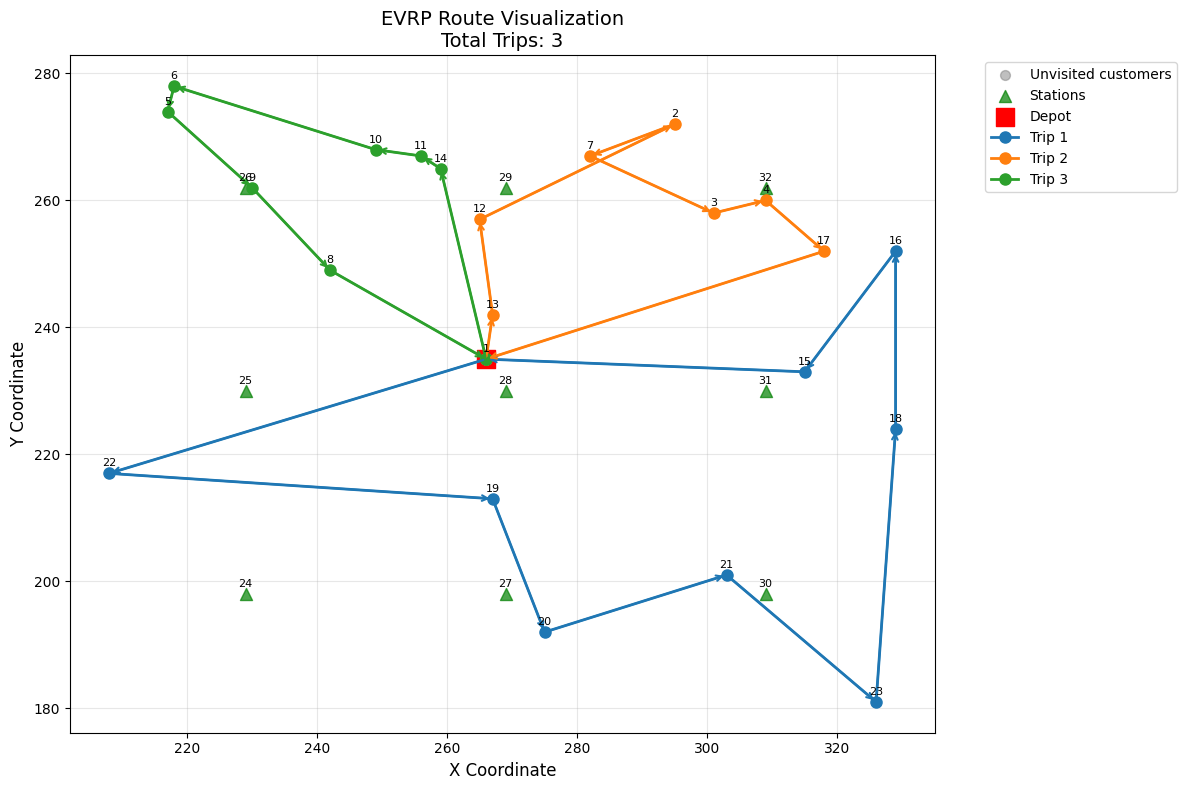

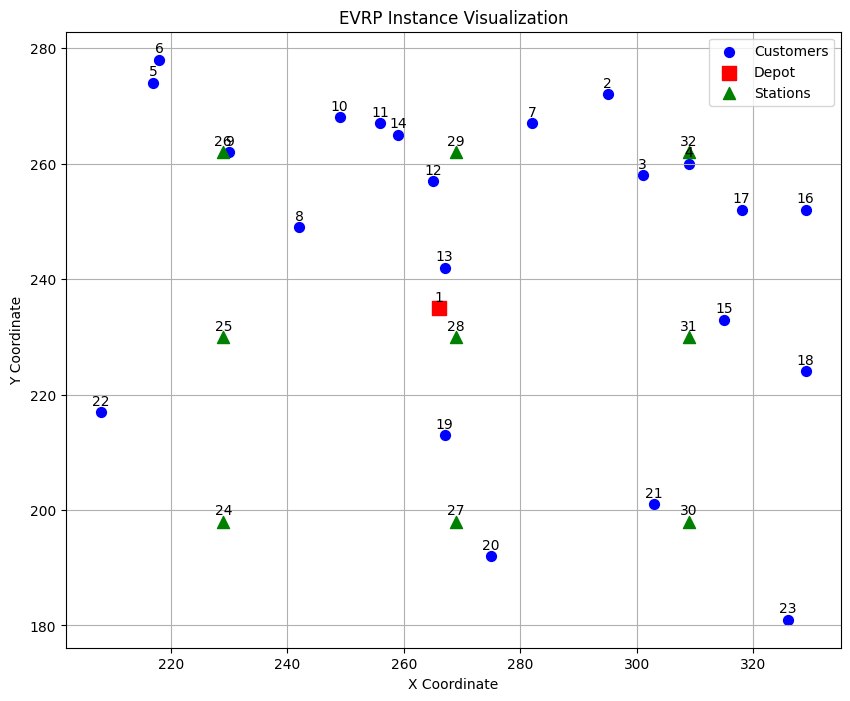

In [5]:
print(calcular_distancia_total(ga.evrp_data, rota))
plot_single_route_with_trips(ga.evrp_data, rota)
plot_evrp_instance(ga.evrp_data)